https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/introduction

https://docs.tweepy.org/en/latest/

https://docs.tweepy.org/en/v3.10.0/cursor_tutorial.html

In [1]:
import pandas as pd
import numpy as np
import json
import os
import io
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import tweepy
from tweepy import Cursor

import re 

import requests
from PIL import Image
from matplotlib.pyplot import imshow

# import urllib.request
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

random_state = 5

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
consumer_key = 'consumer_key'
consumer_secret = 'consumer_secret'
access_token = 'access_token'
access_secret = 'access_secret'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [129]:
# Collect and store tweets
tweet_count = 0
max_tweets = 2000
errors = 0
max_seq_errors = 2000

tweets = []

for status in Cursor(api.user_timeline, 
                     id='ratemyskyperoom', 
                     screen_name='Room Rater',
                     exclude_replies=True).items():

    if tweet_count == max_tweets:
        break
    
    if errors == max_seq_errors:
        break
        
    try: 
        tweet_id = status.id
        tweet_text = status.text
        image_url = status.entities.get('media')[0]['media_url']
        favorites = status.favorite_count

        tweet = {'tweet_id':tweet_id,
                 'tweet_text':tweet_text,
                 'image_url':image_url,
                'favorites':favorites}

        tweets.append(tweet)
        
        
    except:
        errors += 1
        continue
    
    tweet_count += 1
    errors = 0
    
# Store as dataframe
tweet_df = pd.DataFrame(tweets,
                       columns = ['tweet_id',
                                  'tweet_text',
                                  'image_url',
                                  'favorites'])

tweet_df.to_csv('roomratertweets.csv', index=False)

#Resource for reading media_url:
#https://miguelmalvarez.com/2015/03/03/download-the-pictures-from-a-twitter-feed-using-python/

In [2]:
def load_data(tweet_filepath):
    """Input filepath for stored tweets and return dataframe"""
    df = pd.read_csv(tweet_filepath)
    
    return df

In [3]:
df = load_data('roomratertweets.csv')
df.head(4)

,tweet_id,tweet_text,image_url,favorites
0,1364758339079479296,Depth. Love the chair. Art. Classic mantel vie...,http://pbs.twimg.com/media/EvCYedsVkAAhmnb.jpg,189
1,1364755341175480323,Karate chopped pillows. Art. Plant. Add more l...,http://pbs.twimg.com/media/EvCVv9bUYAE-SQx.jpg,111
2,1364730053234290690,Room Rater Fluffy Room. A pineapple can be so ...,http://pbs.twimg.com/media/EvB-v_8VoAcqEHy.jpg,949
3,1364700539817058311,Revisiting. Top room with a view. Plants. Lamp...,http://pbs.twimg.com/media/EvBj5-CVIAMXgzm.jpg,117


In [11]:
# Select records with rating
def clean_data(df):
    """Input raw tweet dataframe and return cleaned dataframe"""
    rated = df[df['tweet_text'].str.contains('/10')]

    rated['rating'] = rated['tweet_text'].str.split('/10').str[0].str.split(' ').str[-1]

    rated['rating'] = rated['rating'].str.extract('(\d+)', expand=False)

    rated_clean = rated[~rated['rating'].isnull()]

    rated_clean['rating'] = rated_clean['rating'].astype(int)
    
    return rated_clean

In [12]:
rated_clean = clean_data(df)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

## Explore

In [14]:
rated_clean.tail(2)

,tweet_id,tweet_text,image_url,favorites,rating
1056,1347387661972107264,Classic Hostage video as only @nytmike can del...,http://pbs.twimg.com/media/ErLh7_ZXMAIVFco.jpg,1322,2
1057,1347386250056097793,"There’s a nice bowl. Swing and miss. Sorry, @S...",http://pbs.twimg.com/media/ErLgpy7WMAARU8a.jpg,611,4


In [15]:
rated_clean[['tweet_id','rating']].groupby('rating').count()

,tweet_id
rating,
0,27
1,4
2,9
3,13
4,16
5,9
6,24
7,70
8,178


<AxesSubplot:xlabel='rating', ylabel='favorites'>

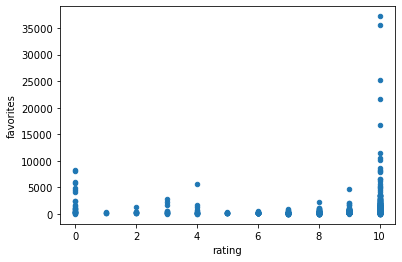

In [16]:
rated_clean.plot.scatter(x='rating',y='favorites')

In [19]:
# Display image
def display_image(df, record):
    image_url = df.image_url.iloc[record]
    text = df.tweet_text.iloc[record]
    view_img = Image.open(requests.get(image_url, stream=True).raw)

    fig, ax = plt.subplots()
    plt.title('Room Rater Review')
    fig.text(.5,.07, text, ha='center', fontsize=9)
    plt.imshow(view_img)
    ax.set_axis_off()
    plt.axis('off')
    
    return plt.show()
    
# https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python

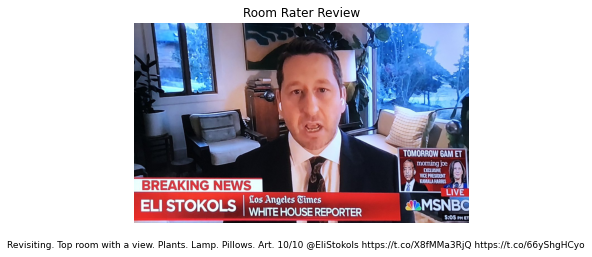

In [22]:
display_image(rated_clean, 3)

## NLP

In [23]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    stop_words = stopwords.words("english")
    
    # Remove URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, " ")
        
    lemmatizer = WordNetLemmatizer()
    
    # Normalize case and remove punctuation and extra spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower().strip())
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [24]:
def build_model():
    """Use Pipeline to build MultiOutputClassifer with parameters selected based on GridSearch"""
    pipeline = Pipeline([
#         ('features', FeatureUnion([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
#             ])),
            
#             ('id_question', QuestionDetector())
        ])),
        
        ('clf', RandomForestClassifier(random_state=random_state))
    ])
    
    # After multiple runs with GridSerachCV, store best parameters in final model
    best_parameters = {
        'clf__min_samples_split': [2]
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [25]:
# X, y, category_names = load_data(database_filepath)
X = rated_clean['tweet_text']
y = rated_clean['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
model = build_model()

In [27]:
model.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__text_pipeline', 'estimator__clf', 'estimator__text_pipeline__memory', 'estimator__text_pipeline__steps', 'estimator__text_pipeline__verbose', 'estimator__text_pipeline__vect', 'estimator__text_pipeline__tfidf', 'estimator__text_pipeline__vect__analyzer', 'estimator__text_pipeline__vect__binary', 'estimator__text_pipeline__vect__decode_error', 'estimator__text_pipeline__vect__dtype', 'estimator__text_pipeline__vect__encoding', 'estimator__text_pipeline__vect__input', 'estimator__text_pipeline__vect__lowercase', 'estimator__text_pipeline__vect__max_df', 'estimator__text_pipeline__vect__max_features', 'estimator__text_pipeline__vect__min_df', 'estimator__text_pipeline__vect__ngram_range', 'estimator__text_pipeline__vect__preprocessor', 'estimator__text_pipeline__vect__stop_words', 'estimator__text_pipeline__vect__strip_accents', 'estimator__text_pipeline__vect__token_pattern', 'estim

In [28]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__min_samples_split=2 ........................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ clf__min_samples_split=2, score=0.980, total=   5.3s
[CV] clf__min_samples_split=2 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] ............ clf__min_samples_split=2, score=0.959, total=   1.7s
[CV] clf__min_samples_split=2 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] ............ clf__min_samples_split=2, score=0.973, total=   1.5s
[CV] clf__min_samples_split=2 ........................................
[CV] ............ clf__min_samples_split=2, score=0.952, total=   1.4s
[CV] clf__min_samples_split=2 ........................................
[CV] ............ clf__min_samples_split=2, score=0.952, total=   1.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.3s finished


GridSearchCV(estimator=Pipeline(steps=[('text_pipeline',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer(tokenizer=<function tokenize at 0x000001CE6C573A60>)),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('clf',
                                        RandomForestClassifier(random_state=5))]),
             param_grid={'clf__min_samples_split': [2]}, verbose=3)

In [29]:
def evaluate_model(model, X_test, y_test):
    """Input model, X_test, y_test, and category names to return classification report for each category"""
    y_pred = model.predict(X_test)
    
    classif_report = classification_report(y_test, y_pred)
    
    return classif_report

In [40]:
import sklearn
from sklearn.metrics import r2_score, accuracy_score, recall_score,precision_score

In [33]:
y_pred = model.predict(X_test)
sklearn.metrics.r2_score(y_test, y_pred)

0.8672422298963987

In [37]:
accuracy_score(y_test, y_pred)

0.9836956521739131

In [47]:
precision_score(y_test, y_pred, average='weighted')

0.9785714285714285

In [48]:
recall_score(y_test, y_pred, average='weighted')

0.9836956521739131

## View results

In [63]:
rated_copy = rated_clean.copy()
rated_copy['preds'] = pd.Series(y_pred)
rated_copy.head()

,tweet_id,tweet_text,image_url,favorites,rating,preds
0,1364758339079479296,Depth. Love the chair. Art. Classic mantel vie...,http://pbs.twimg.com/media/EvCYedsVkAAhmnb.jpg,189,10,10.0
1,1364755341175480323,Karate chopped pillows. Art. Plant. Add more l...,http://pbs.twimg.com/media/EvCVv9bUYAE-SQx.jpg,111,8,8.0
2,1364730053234290690,Room Rater Fluffy Room. A pineapple can be so ...,http://pbs.twimg.com/media/EvB-v_8VoAcqEHy.jpg,949,10,10.0
3,1364700539817058311,Revisiting. Top room with a view. Plants. Lamp...,http://pbs.twimg.com/media/EvBj5-CVIAMXgzm.jpg,117,10,10.0
4,1364699445883932673,Checking in. Mantel view. Shapes. Art. Lightin...,http://pbs.twimg.com/media/EvBi6UiVkAYI82Q.jpg,380,10,10.0


In [65]:
rated_copy['diff'] = rated_copy['rating']-rated_copy['preds']

In [77]:
rated_copy.sort_values(by=['diff'], ascending=False).head(15)

,tweet_id,tweet_text,image_url,favorites,rating,preds,diff
20,1364374905341370368,We are suckers for a baby grand. Love the blue...,http://pbs.twimg.com/media/Eu87vViU4AAYNTC.jpg,1530,10,0.0,10.0
13,1364591593861255168,Great light. Plant. Spacing. Objects. Books. W...,http://pbs.twimg.com/media/EvAA0eXVIA0_r0k.jpg,576,10,0.0,10.0
174,1361676637348237313,Are Forbes covers art? Point for extra hat. Ix...,http://pbs.twimg.com/media/EuWlryCXYAMpEuF.jpg,62,7,0.0,7.0
69,1363344803052670980,Lights. Pillows. Depth. A calendar. Always art...,http://pbs.twimg.com/media/EuuS3uXVkAIt9_y.jpg,492,10,3.0,7.0
35,1364027004803162123,Love the Asian art. Buddhas are always points....,http://pbs.twimg.com/media/Eu3_VMDU4AEEOV-.jpg,264,9,2.0,7.0
53,1363620031813197826,Checking in with the Hoovalons. New room. Grea...,http://pbs.twimg.com/media/EuyNMHyVkAABN8c.jpg,261,10,4.0,6.0
74,1363308588635054082,Checking in. Great flower work. Mirror. Ready ...,http://pbs.twimg.com/media/Eutx7xzU4AIXsDO.jpg,349,10,6.0,4.0
54,1363551207772495872,Lights just back on. Still boiling water. All ...,http://pbs.twimg.com/media/EuxOmDuUUAMf9zJ.jpg,347,10,6.0,4.0
87,1363168600811479040,Love the pattern in back. Plant. Twigs. Raise ...,http://pbs.twimg.com/media/EurynYvVEAICUeQ.jpg,176,8,4.0,4.0
181,1361522295555072000,RT @JoelPearl: This gave Glencairn Station an ...,http://pbs.twimg.com/media/EuUYmhlWQAQHzix.jpg,0,10,6.0,4.0


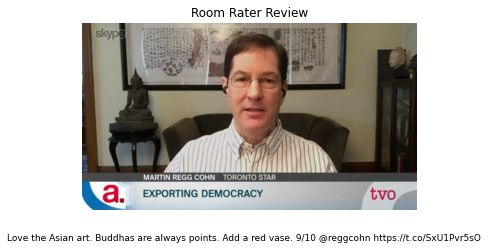

In [76]:
display_image(rated_copy,35)

## Old

In [59]:
y_test[['preds']]

preds    [10, 8, 10, 10, 10, 10, 8, 9, 10, 10, 8, 10, 8...
Name: rating, dtype: object

In [55]:
y_test['preds'] = y_pred

In [50]:
rated_eval = pd.merge(rated_clean, y_test[['preds']],
                     how='left',
                     left_index=True,right_index=True)

In [61]:
rated_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 0 to 1057
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    917 non-null    int64 
 1   tweet_text  917 non-null    object
 2   image_url   917 non-null    object
 3   favorites   917 non-null    int64 
 4   rating_x    917 non-null    int32 
 5   rating_y    0 non-null      object
dtypes: int32(1), int64(2), object(3)
memory usage: 86.6+ KB


In [30]:
evaluate_model(model, X_test, y_test)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       1.00      0.75      0.86         4\n           2       1.00      1.00      1.00         4\n           3       1.00      1.00      1.00         4\n           4       1.00      1.00      1.00         2\n           5       0.00      0.00      0.00         1\n           6       1.00      1.00      1.00         8\n           7       1.00      1.00      1.00        16\n           8       1.00      1.00      1.00        42\n           9       0.97      0.97      0.97        35\n          10       0.97      1.00      0.99        68\n\n    accuracy                           0.98       184\n   macro avg       0.89      0.87      0.88       184\nweighted avg       0.98      0.98      0.98       184\n'